# Random Forest: Bosques

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

In [3]:
bd5.dtypes

[('Year', 'int'),
 ('Month', 'int'),
 ('DayofMonth', 'int'),
 ('DayOfWeek', 'int'),
 ('CRSDepTime', 'int'),
 ('UniqueCarrier', 'string'),
 ('TailNum', 'string'),
 ('ArrDelay', 'double'),
 ('DepDelay', 'double'),
 ('Origin', 'string'),
 ('Dest', 'string'),
 ('Distance', 'double'),
 ('Cancelled', 'double'),
 ('Diverted', 'double'),
 ('CarrierDelay', 'double'),
 ('WeatherDelay', 'double'),
 ('NASDelay', 'double'),
 ('SecurityDelay', 'double'),
 ('LateAircraftDelay', 'double'),
 ('LogD', 'double'),
 ('Retraso', 'int'),
 ('RetrasoNeto', 'double'),
 ('Horario', 'int')]

In [4]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='UniqueCarrier',outputCol='IndexUniqueCarrier') #el índice empieza en el 0!
bd6=indexer.fit(bd5).transform(bd5)

bd6.groupBy('UniqueCarrier','IndexUniqueCarrier').count().sort('IndexUniqueCarrier').show()


+-------------+------------------+-----+
|UniqueCarrier|IndexUniqueCarrier|count|
+-------------+------------------+-----+
|           AA|               0.0| 8853|
|           UA|               1.0| 6112|
|           WN|               2.0| 5395|
|           DL|               3.0| 4239|
|           VX|               4.0| 1703|
|           NK|               5.0| 1581|
|           F9|               6.0| 1295|
|           OO|               7.0| 1166|
|           B6|               8.0|  121|
|           EV|               9.0|    1|
+-------------+------------------+-----+



## Regression Random Forest

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','IndexUniqueCarrier'],
    outputCol='features')

bd7 = a1.transform(bd6).select(col("ArrDelay").alias("label"),'features')

## Partición Test - Train

In [6]:
(bd_train, bd_test) = bd7.randomSplit([0.7, 0.3],seed=123)
print(bd_train.count())
print(bd_test.count())

21334
9132


In [7]:
from pyspark.ml.regression import RandomForestRegressor
from time import time

start_time = time()

# Train a RandomForest model.
rf = RandomForestRegressor(labelCol="label", 
     featuresCol="features", 
     numTrees=500,
     maxDepth=5,
     seed = 1,
     subsamplingRate=1.0,
     featureSubsetStrategy="auto")
     
model = rf.fit(bd_train)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

pred = model.transform(bd_train)

Time to train model: 37.509 seconds


In [8]:
pred.select('label','prediction').show()

+-----+--------------------+
|label|          prediction|
+-----+--------------------+
|-53.0|  -0.313039908263667|
|-47.0|  0.6786685848774878|
|-46.0|-0.32094384577155743|
|-46.0|   -2.56184150233535|
|-46.0|  -5.457637214247127|
|-44.0| -0.7942632797248129|
|-44.0|-0.09748696899401113|
|-44.0|   1.152007746530329|
|-43.0|  3.1966528145820545|
|-42.0|  -3.181110885273408|
|-42.0| 0.10279044853437228|
|-42.0|  -5.705594225939158|
|-42.0|  1.8894521060256915|
|-42.0|   3.227513473661244|
|-42.0| -1.2474346140576684|
|-42.0|  0.5776801690354412|
|-41.0|-0.35742297386864175|
|-41.0|  -6.142186418022908|
|-41.0| -2.3233224544649675|
|-40.0|  -6.201194776178803|
+-----+--------------------+
only showing top 20 rows



In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="r2").evaluate(pred))

0.636557060656907


In [10]:
pred2 = model.transform(bd_test)
print(RegressionEvaluator(metricName="r2").evaluate(pred2))

0.6065254513838018


In [11]:
# RandomForestRegressor(featuresCol="features", 
#    labelCol="label",
#    predictionCol="prediction",
#    maxDepth=5,
#    maxBins=32,
#    minInstancesPerNode=1,
#    minInfoGain=0.0,
#    maxMemoryInMB=256, 
#    impurity="variance", 
#    subsamplingRate=1.0, 
#    seed=None, 
#    numTrees=20,
#    featureSubsetStrategy="auto"  / "sqrt" / "onethird" / "log2" / "all")

## Classification Random Forest

In [12]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','IndexUniqueCarrier'],
    outputCol='features')

bd7 = a1.transform(bd6).select(col("Retraso").cast('double').alias("label"),'features')

stringIndexer = StringIndexer(inputCol = 'label', outputCol = 'indexed')
sI = stringIndexer.fit(bd7)
bd7 = sI.transform(bd7)

In [13]:
(bd_train, bd_test) = bd7.randomSplit([0.7, 0.3],seed=123)
print(bd_train.count())
print(bd_test.count())

21334
9132


In [14]:
from pyspark.ml.classification import RandomForestClassifier

start_time = time()

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexed", 
     featuresCol="features", 
     numTrees=500,
     maxDepth=3, 
     seed = 1,
     featureSubsetStrategy="sqrt",
     impurity='gini') 

model = rf.fit(bd_train)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

pred = model.transform(bd_train)


Time to train model: 9.966 seconds


In [15]:
pred.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [16]:
pred.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 4233|
|  0.0|       0.0|15013|
|  0.0|       1.0|  449|
|  1.0|       0.0| 1639|
+-----+----------+-----+



### Curva ROC


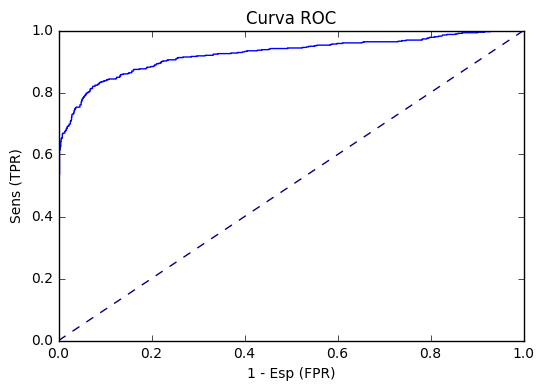

In [28]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

secondelement=udf(lambda v:float(v[1]),FloatType())
pred2=pred.withColumn('probs',secondelement('probability'))


#Dibujamos la curva ROC

pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()
fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('1 - Esp (FPR)')
plt.ylabel('Sens (TPR)')
plt.title('Curva ROC')
plt.show()

In [29]:
pred2.show()

+-----+--------------------+-------+--------------------+--------------------+----------+-----------+
|label|            features|indexed|       rawPrediction|         probability|prediction|      probs|
+-----+--------------------+-------+--------------------+--------------------+----------+-----------+
|  0.0|[-21.0,868.0,6.0,...|    0.0|[463.904354561326...|[0.92780870912265...|       0.0| 0.07219129|
|  0.0|[-17.0,888.0,7.0,...|    0.0|[446.202338054965...|[0.89240467610993...|       0.0|0.107595325|
|  0.0|[-17.0,1440.0,1.0...|    0.0|[463.662725445575...|[0.92732545089115...|       0.0| 0.07267455|
|  0.0|[-17.0,1744.0,1.0...|    0.0|[464.344563272082...|[0.92868912654416...|       0.0| 0.07131087|
|  0.0|[-16.0,641.0,6.0,...|    0.0|[448.237154237273...|[0.89647430847454...|       0.0| 0.10352569|
|  0.0|[-16.0,888.0,3.0,...|    0.0|[446.067963818024...|[0.89213592763604...|       0.0|0.107864074|
|  0.0|[-15.0,731.0,4.0,...|    0.0|[448.322652525504...|[0.89664530505100...|    

In [31]:
predtest = model.transform(bd_test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE
print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))
print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(predtest))


AUC= 0.9183324583747017
AUC= 0.9163139356896335
